### Swamp sparrow custom parsing
- This dataset has:
    - A number of CSVs with individual, element, and song information
- The data was originally in [luscinia](https://rflachlan.github.io/Luscinia/) format (h2 db). I exported individual tables as CSVs so that I could import them into python. 
- Because the data is already well annotated, all this notebook does is save data as WAV and generate JSONs corresponding to the data. 
- Dataset origin:
    - https://figshare.com/articles/SwampSparrow_luscdb_zip/5625310

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DATASET_ID = 'swamp_sparrow'

In [3]:
from avgn.utils.general import prepare_env

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
prepare_env()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=GPU


### Import relevant packages

In [5]:
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm
import pandas as pd
pd.options.display.max_columns = None
import librosa
from datetime import datetime
import numpy as np

In [6]:
import avgn
from avgn.custom_parsing.lachlan_swampsparrow import string2int16, annotate_bouts
from avgn.utils.paths import DATA_DIR

### Load data in original format

In [7]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2020-04-22_20-24-02'

In [8]:
DSLOC = avgn.utils.paths.Path('/mnt/cube/Datasets/swampsparrow/swampsparrow-xml/')

In [9]:
individual = pd.read_csv(DSLOC / 'INDIVIDUAL.csv')
individual[:3]

,ID,NUMSONGS,NAME,SPECID,POPID,LOCDESC,GRIDTYPE,GRIDX,GRIDY,SEX,RANK,AGE
0,48,NaN,MIWAT01,Swamp Sparrow,"Waterloo, MI",NaN,UTM,42.360523,-84.1779184,NaN,NaN,NaN
1,49,NaN,MIWAT02,Swamp Sparrow,"Waterloo, MI",NaN,UTM,42.360924,-84.1781069,NaN,NaN,NaN
2,50,NaN,MIWAT03,Swamp Sparrow,"Waterloo, MI",,UTM,42.360829,-84.1782932,NaN,NaN,NaN


In [10]:
syllables = pd.read_csv(DSLOC / 'SYLLABLE.csv')
syllables[:3]

,SONGID,STARTTIME,ENDTIME
0,2531,1220,1536
1,2531,1223,1297
2,2531,1306,1378


In [11]:
elements = pd.read_csv(DSLOC / 'ELEMENT.csv')
elements[:3]

,ID,SONGID,SIGNAL,PEAKFREQ,FUNDFREQ,MEANFREQ,MEDIANFREQ,PEAKFREQCHANGE,FUNDFREQCHANGE,MEANFREQCHANGE,MEDIANFREQCHANGE,HARMONICITY,WIENER,BANDWIDTH,AMPLITUDE,REVERBERATION,TRILLAMP,TRILLRATE,POWERSPECTRUM,STARTTIME,OVERALLPEAKFREQ1,OVERALLPEAKFREQ2,TIMELENGTH,GAPBEFORE,GAPAFTER,TIMESTEP,FRAMELENGTH,MAXF,WINDOWMETHOD,DY,DYNRANGE,DYNCOMP,ECHORANGE,ECHOCOMP
0,1820682,2011,3 177 145 139 3 178 146 137 3 179 146 137 3 18...,4263.57421875 3832.91015625 15.0 0.0 4062.5976...,4283.673733543762 3815.8396713317325 19.0 0.0 ...,4270.3427222250075 3826.5109432227587 19.0 0.0...,4306.266418097342 3843.9194083976013 14.0 3.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,0.007604770101606771 0.006679462853040866 0.0 ...,0.6417240713887844 0.5782139509622957 13.0 0.0...,-0.028506678217236365 -0.1948960193124872 19.0...,301.46484375 -86.1328125 18.0 0.0 -76.19441105...,35.679351806640625 11.216655731201172 19.0 11....,100.0 0.5 2.0 8.5 27.82051282051282 43.5 50.0 ...,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,40.0 40.0 0.0 0.0 40.0 40.0 40.0 40.0 40.0 40....,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,177,4134.375,4134.375,19.0,-10000.0,7.5,0.5,5.0,10000,NaN,43.066406,200.0,36.0,25,1.0
1,1820683,2011,3 230 60 57 3 231 63 57 3 232 64 57 3 233 66 5...,7407.421875 3100.78125 0.0 42.0 4587.030418882...,7389.1988844382295 3027.87251546893 0.0 42.5 4...,7409.13028952881 3048.31062821831 0.0 43.0 455...,7426.946155956237 3060.4056743941146 0.0 44.0 ...,-0.012553735012542117 -0.03338982031684048 28....,-0.012553735012542117 -0.03338982031684048 28....,-0.012553735012542117 -0.03338982031684048 28....,-0.012553735012542117 -0.03338982031684048 28....,0.6734669894201485 0.5877230486423247 16.5 5.0...,-0.04550707709243979 -0.2510391688153517 0.0 1...,516.796875 -86.1328125 17.5 0.0 -75.5952875664...,35.076597929000854 7.0471343994140625 0.0 17.5...,100.0 0.5 0.0 7.0 26.829787234042552 100.0 100...,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,40.0 40.0 0.0 0.0 40.0 40.0 40.0 40.0 40.0 40....,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,230,4565.039,3186.914,46.5,7.5,2.5,0.5,5.0,10000,NaN,43.066406,200.0,36.0,25,1.0
2,1820684,2011,5 328 115 111 103 102 3 329 126 101 3 330 134 ...,4995.703125 3316.11328125 0.0 4.5 4117.1484375...,5137.39993108298 3399.0993019123976 0.0 4.0 42...,5047.68551414882 3327.0782209257077 0.0 4.5 41...,5064.723596006633 3325.6770996024384 0.0 4.5 4...,-0.12936507276325204 -0.12951987178017654 0.0 ...,-0.12936507276325204 -0.12951987178017654 0.0 ...,-0.12936507276325204 -0.12951987178017654 0.0 ...,-0.12936507276325204 -0.12951987178017654 0.0 ...,0.7165497097891279 0.5925254874604499 0.0 4.0 ...,-0.047124243903335805 -0.27740346752434225 0.0...,1421.19140625 -86.1328125 2.0 0.5 482.34375 43...,33.46252632141113 24.335822105407715 4.5 1.5 2...,100.0 47.5 1.5 0.5 87.35 72.0 47.5 54.0 100.0 ...,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,40.0 40.0 0.0 0.0 40.0 40.0 40.0 40.0 40.0 40....,0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,328,4263.574,3402.246,4.5,2.5,28.5,0.5,5.0,10000,NaN,43.066406,200.0,36.0,25,1.0


In [27]:
elements.columns

Index(['ID', 'SONGID', 'SIGNAL', 'PEAKFREQ', 'FUNDFREQ', 'MEANFREQ',
       'MEDIANFREQ', 'PEAKFREQCHANGE', 'FUNDFREQCHANGE', 'MEANFREQCHANGE',
       'MEDIANFREQCHANGE', 'HARMONICITY', 'WIENER', 'BANDWIDTH', 'AMPLITUDE',
       'REVERBERATION', 'TRILLAMP', 'TRILLRATE', 'POWERSPECTRUM', 'STARTTIME',
       'OVERALLPEAKFREQ1', 'OVERALLPEAKFREQ2', 'TIMELENGTH', 'GAPBEFORE',
       'GAPAFTER', 'TIMESTEP', 'FRAMELENGTH', 'MAXF', 'WINDOWMETHOD', 'DY',
       'DYNRANGE', 'DYNCOMP', 'ECHORANGE', 'ECHOCOMP'],
      dtype='object')

In [19]:
len(elements)

97613

In [13]:
import matplotlib.pyplot as plt

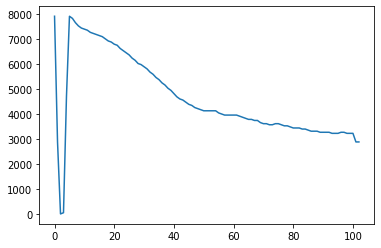

In [14]:
plt.plot([float(i) for i in elements.PEAKFREQ.values[10].split(' ')[:-1]])

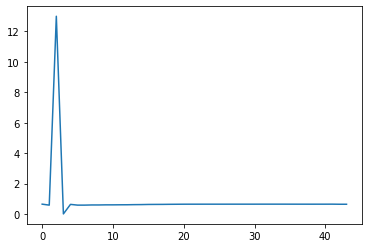

In [15]:
plt.plot([float(i) for i in elements.HARMONICITY.values[0].split(' ')[:-1]])

In [16]:
songdata = pd.read_csv(DSLOC / 'SONGDATA.csv')
songdata[:3]

,ID,INDIVIDUALID,NAME,ECHOCOMP,ECHORANGE,DYNCOMP,DYNRANGE,MAXFREQ,FRAMELENGTH,TIMESTEP,FILTERCUTOFF,WINDOWMETHOD,DX,DY,SAMPLERATE,USER,CALL_LOCATION,CALL_CONTEXT,RECORDINGEQUIPMENT,RECORDER,NOISE1,NOISE2,NOISE3,TIME,QUALITY,TYPE,CUSTOM0,CUSTOM1
0,2193,561,TypeS-CentroidA-C2.wav,1.0,50,40.0,200,10000,5.0,0.5,1000.0,1,0.0,0.0,0,NaN,,,Sony PCM D50 / Shure SM57 / Sony PBR330,R F Lachlan,0.0,200,15,1301475691000,,,NaN,NaN
1,2011,251,SWSP09HVTIV29K1.wav,1.0,50,40.0,200,10000,5.0,0.5,1000.0,1,0.0,0.0,0,NaN,,,Sony PCM D50 / Shure SM57 / Sony PBR330,R F Lachlan,0.0,200,15,1259216618000,,,NaN,NaN
2,2010,251,SWSP09HVTIV29GG1.wav,1.0,50,40.0,200,10000,5.0,0.5,1000.0,1,0.0,0.0,0,NaN,,,Sony PCM D50 / Shure SM57 / Sony PBR330,R F Lachlan,0.0,200,15,1259216653000,,,NaN,NaN


In [17]:
wavs = pd.read_csv(DSLOC / 'WAVS.csv')
wavs[:3]

,ID,SONGID,FILENAME,WAV,SAMPLERATE,FRAMESIZE,STEREO,BIGEND,SIGNED,SSIZEINBITS,TIME
0,71,71,PymConneaut08T50C-Z.wav,ebffe8ffdbffe3ffdfffddffe2ffdfffe3ffc8ffc4ffcd...,44100.0,2,1,0,1,16,1222840401000
1,72,72,PymConneaut08T42B-RA,c7ffb3ffc6ffd7ffd8fff8fffbff0400eaffdeffc2ffa8...,44100.0,2,1,0,1,16,1222837577000
2,73,73,PymConneaut08T42A-A.wav,e7ffe9fff0fffcfff6fff3fffffff2ffeeffebffe2fffa...,44100.0,2,1,0,1,16,1222837530000


In [28]:
len(wavs)

1870

In [55]:
wavnames = [i[:-4] if '.wav' in i else i for i in wavs.FILENAME.values]

In [56]:
len(np.unique(wavnames))

1869

In [24]:
labels = pd.read_excel(DATA_DIR / 'swamp_sparrow' / 'Classification160Final.xlsx', sheet_name='Classifications')

In [25]:
labels[:3]

,0.2628435522310395,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176,Unnamed: 177,Unnamed: 178,Unnamed: 179,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Unnamed: 200,Unnamed: 201,Unnamed: 202,Unnamed: 203,Unnamed: 204,Unnamed: 205,Unnamed: 206,Unnamed: 207,Unnamed: 208,Unnamed: 209,Unnamed: 210,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255,Unnamed: 256,Unnamed: 257,Unnamed: 258,Unnamed: 259,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Unnamed: 264,Unnamed: 265,Unnamed: 266,Unnamed: 267,Unnamed: 268,Unnamed: 269,Unnamed: 270,Unnamed: 271,Unnamed: 272,Unnamed: 273,Unnamed: 274,Unnamed: 275,Unnamed: 276,Unnamed: 277,Unnamed: 278,Unnamed: 279,Unnamed: 280,Unnamed: 281,Unnamed: 282,Unnamed: 283,Unnamed: 284,Unnamed: 285,Unnamed: 286,Unnamed: 287,Unnamed: 288,Unnamed: 289,Unnamed: 290,Unnamed: 291,Unnamed: 292,Unnamed: 293,Unnamed: 294,Unnamed: 295,Unnamed: 296,Unnamed: 297,Unnamed: 298,Unnamed: 299,Unnamed: 300,Unnamed: 301,Unnamed: 302,Unnamed: 303,Unnamed: 304,Unnamed: 305,Unnamed: 306,Unnamed: 307,Unnamed: 308,Unnamed: 309,Unnamed: 310,Unnamed: 311,Unnamed: 312,Unnamed: 313,Unnamed: 314,Unname

In [49]:
wavnames2 = [i.split(',')[0] for i in labels[0.2628435522310395].values]

845

In [59]:
len(np.array(wavnames))

1870

In [57]:
len(wavname == np.array(wavnames))

1870

In [61]:
for wavname in wavnames2:
    wavlocs = np.where(wavname == np.array(wavnames))[0]
    if len(wavlocs)> 0:
        breakme

NameError: name 'breakme' is not defined

In [64]:
wavs.FILENAME.values[wavlocs[0]]

'PymConneaut08T45B-WB.wav'

In [26]:
len(labels)

1890

In [ ]:
len

### generate wavs and textgrids

In [ ]:
"""with Parallel(n_jobs=1, verbose=10) as parallel:
    parallel(
        delayed(annotate_bouts)(
            row, 
            songdata[songdata.ID == row.ID].iloc[0], 
            individual[individual.ID == songdata[songdata.ID == row.ID].iloc[0].INDIVIDUALID].iloc[0], 
            elements[elements.SONGID == row.SONGID], 
            syllables[syllables.SONGID == row.SONGID], 
            DT_ID)
        for idx, row in tqdm(wavs.iterrows(), total=len(wavs))
    );
"""

In [15]:
"""for idx, row in tqdm(wavs.iterrows(), total=len(wavs)):
    annotate_bouts(
            row, 
            songdata[songdata.ID == row.ID].iloc[0], 
            individual[individual.ID == songdata[songdata.ID == row.ID].iloc[0].INDIVIDUALID].iloc[0], 
            elements[elements.SONGID == row.SONGID], 
            syllables[syllables.SONGID == row.SONGID], 
            DT_ID
    )"""

'for idx, row in tqdm(wavs.iterrows(), total=len(wavs)):\n    annotate_bouts(\n            row, \n            songdata[songdata.ID == row.ID].iloc[0], \n            individual[individual.ID == songdata[songdata.ID == row.ID].iloc[0].INDIVIDUALID].iloc[0], \n            elements[elements.SONGID == row.SONGID], \n            syllables[syllables.SONGID == row.SONGID], \n            DT_ID\n    )'